In [1]:
import EOSutils as meos

import numpy as np
import matplotlib.pyplot as plt

import matplotlib.style
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.cm as cmx
from mpl_toolkits.axes_grid1 import make_axes_locatable

mpl.style.use('classic')

from astropy.table import Table
from astropy import units as u
from astropy.constants import G

import mesa_helper as mh
import os
import shutil
import copy

from scipy import ndimage, interpolate, optimize

from eos import aqua_eos, fe_eos
import pickle

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
def read_in_SESAME(sesamefile):
    """
    SESAME/ANEOS header looks like:

    # Material SS08 water
    # version_date                                                (YYYYMMDD)
    # num_rho  num_T
    # rho[0]   rho[1]  ...  rho[num_rho-1]                        (kg/m^3)
    # T[0]     T[1]    ...  T[num_T-1]                            (K)
    # u[0, 0]                 P[0, 0]     c[0, 0]     s[0, 0]     (J/kg, Pa, m/s, J/K/kg)
    # u[1, 0]                 ...         ...         ...
    # ...                     ...         ...         ...
    # u[num_rho-1, 0]         ...         ...         ...
    # u[0, 1]                 ...         ...         ...
    # ...                     ...         ...         ...
    # u[num_rho-1, num_T-1]   ...         ...         s[num_rho-1, num_T-1]
    20220714 
    275 218 
    """
    num_rho = None
    num_T = None

    
    with open(sesamefile) as file:
        for i,line in enumerate(file):
            if i==13:
                num_rho, num_T = line.split(" ")[:-1] #to avoid trailing newline
                num_rho = int(num_rho)
                num_T = int(num_T)
                rho_arr = np.zeros((num_rho))
                T_arr = np.zeros((num_T))
            if i==14:
                rho_list = line.split(" ")[:-1]
                for j in range(len(rho_list)):
                    rho_arr[j] = float(rho_list[j])
            if i==15:
                T_list = line.split(" ")[:-1]
                for j in range(len(T_list)):
                    T_arr[j] = float(T_list[j])
                break

    # num_rho is 275
    # num_T is 218
    rhogrid, Tgrid = np.meshgrid(rho_arr, T_arr) # (218, 275)

    Ugrid = np.zeros_like(rhogrid)
    Pgrid = np.zeros_like(rhogrid)
    Sgrid = np.zeros_like(rhogrid)

    data = np.genfromtxt(sesamefile, skip_header=16)
    #print(np.shape(data))

    for i in range(len(T_arr)):
        Ugrid[i] = data[:,0][i*num_rho : (i+1)*num_rho]
        Pgrid[i] = data[:,1][i*num_rho : (i+1)*num_rho]
        Sgrid[i] = data[:,3][i*num_rho : (i+1)*num_rho]

    # convert to cgs
    rhogrid = rhogrid * 1.e-3 # kg/m^3 to g/cm^3
    Ugrid = Ugrid * 1.e4      # J/kg to erg/g
    Pgrid = Pgrid * 10        # Pa to dyn/cm^2, aka erg/cm^3 
    Sgrid = Sgrid * 1.e4      # J/(kg*K) to erg/(g*K)

    # for SESAME only, not ANEOS
    # get rid of first column and first row, which correspond to density = 0, temperature = 0 respectively
    if "SESAME" in sesamefile or "SS08" in sesamefile:
        rhogrid = rhogrid[1:][:,1:]
        Tgrid = Tgrid[1:][:,1:]
        Ugrid = Ugrid[1:][:,1:]
        Pgrid = Pgrid[1:][:,1:]
        Sgrid = Sgrid[1:][:,1:]

    log10rhogrid = np.log10(rhogrid)
    log10Tgrid = np.log10(Tgrid)
    log10Ugrid = np.log10(Ugrid)
    log10Pgrid = np.log10(Pgrid)
    log10Sgrid = np.log10(Sgrid)
    return log10rhogrid, log10Tgrid, log10Ugrid, log10Pgrid, log10Sgrid
    

In [3]:
class SESAMEtable(object):
    def __init__(self, filename, units='cgs', **kwargs):
        self.filename = filename

        if units == 'cms' or units == 'cgs' or units == 'CMS':
            self.units = units
        else: 
            print('units must be cgs or mks or CMS (T [K], P [GPa], rho [g/cm^3], U [MJ/kg], S [MJ/kg/K])')
        
        self.Z = 1.
        self.X = 0.
        self.Y = 0.

        self.log10rhogrid, self.log10Tgrid, self.log10Ugrid, self.log10Pgrid, self.log10Sgrid = read_in_SESAME(filename)

        if self.units == 'CMS':
            self.log10Pgrid = self.log10Pgrid - 10 #convert to GPa for easy comparison with CMS19 (and recall this is a logarithmic quantity)
            self.log10Sgrid = self.log10Sgrid - 10 #convert to MJ kg^-1 K^-1 for easy comparison with CMS19 (and recall this is a logarithmic quantity)
            self.log10Ugrid = self.log10Ugrid - 10 #convert to MJ kg^-1 for easy comparison with CMS19 (and recall this is a logarithmic quantity)

        elif self.units == 'mks':
            self.log10Pgrid = self.log10Pgrid - 1 # convert P to Pa
            self.log10rhogrid = self.log10rhogrid + 3 # convert rho to kg m^-3
            self.log10Sgrid = self.log10Sgrid - 4 # convert S to J kg^-1 K^-1
            self.log10Ugrid = self.log10Ugrid - 4 # convert U to J kg^-1
                
        self.independent_arr_1 = np.unique(self.log10rhogrid[0]) #unique rho
        self.independent_arr_2 = np.unique(self.log10Tgrid[:,0]) #unique T

        self.independent_var_1 = 'rho'
        self.independent_var_2 = 'T'

        self.nrho = len(self.independent_arr_1)
        self.nT = len(self.independent_arr_2)
        

In [4]:
def read_in_AQUA(aquafile="/Users/emily/Documents/astro/giant_planets/MESA_EoS/eos/aqua/aqua_eos_rhot_v1_0.dat"):
    """
    # Label     Unit     Format  Description                                                                  
    #-----------------------------------------------------------------------------------------------#--------------------------------------
    # rho       kg/m^3   E14.8   Density     (1501 x log spaced)                                              
    # temp      K        E14.8   Temperature ( 301 x log spaced)                                              
    # press     Pa       E14.8   Pressure                                                                     
    # ad_grad   1        E14.8   Adiabatic temperature gradient, (dlog(T)/dlog(P))_S                          
    # s         J/(kg*K) E14.8   Specific entropy                                                             
    # u         J/kg     E14.8   Specific internal energy                                                     
    # c         m/s      E14.8   Bulk speed of sound                                                          
    # mmw       kg/mol   E14.8   Mean molecular weight                                                        
    # x_ion     1        E14.8   Ionization fraction   ( x_ion = N_e/N_tot )                                  
    # x_d       1        E14.8   Dissociation fraction ( x_d   = 1 - N_H2O/N_tot )                            
    # phase     1        I3      Phase id (vapor+ice: 0, vapor+liquid: 1, ice+liquid: 2, vapor: 3, #liquid: 4, supercritical+superionic: 5,
    #                            ice-Ih: -1, ice-II: -2, ice-III: -3, ice-V: -5, ice-VI:-6, ice-VII/#X: -7, ice-Ih+ice-II: -12,            
    #                            ice-Ih+ice-III: -13, ice-II+ice-III: -23, ice-II+ice-V: -25, ice-#II+ice-VI: -26,ice-III+ice-V: -35,      
    #                            ice-III+ice-VI: -36, ice-VI+ice-VII: -67, ice-X+superionic: -10)             
    """
    
    aquatable = np.genfromtxt(aquafile)

    rho_arr = np.unique(aquatable[:,0])
    T_arr = np.unique(aquatable[:,1])
    num_rho = len(rho_arr)
    num_T = len(T_arr)

    Tgrid, rhogrid = np.meshgrid(T_arr, rho_arr) #(1501, 301)

    Ugrid = np.zeros_like(rhogrid)
    Pgrid = np.zeros_like(rhogrid)
    Sgrid = np.zeros_like(rhogrid)

    for i in range(len(rho_arr)):
        Pgrid[i] = aquatable[:,2][i*num_T : (i+1)*num_T]
        Sgrid[i] = aquatable[:,4][i*num_T : (i+1)*num_T]
        Ugrid[i] = aquatable[:,5][i*num_T : (i+1)*num_T]

    # convert to cgs
    rhogrid = rhogrid * 1.e-3 # kg/m^3 to g/cm^3
    Ugrid = Ugrid * 1.e4      # J/kg to erg/g
    Pgrid = Pgrid * 10        # Pa to dyn/cm^2, aka erg/cm^3 
    Sgrid = Sgrid * 1.e4      # J/(kg*K) to erg/(g*K)
    
    log10rhogrid = np.log10(rhogrid)
    log10Tgrid = np.log10(Tgrid)
    log10Ugrid = np.log10(Ugrid)
    log10Pgrid = np.log10(Pgrid)
    log10Sgrid = np.log10(Sgrid)
   
    return log10rhogrid, log10Tgrid, log10Ugrid, log10Pgrid, log10Sgrid

In [5]:
class AQUAtable(object):
    def __init__(self, filename="/Users/emily/Documents/astro/giant_planets/MESA_EoS/AQUA/Tables/aqua_eos_rhot_v1_0.dat", units='cgs', **kwargs):
        self.filename = filename

        if units == 'cms' or units == 'cgs' or units == 'CMS':
            self.units = units
        else: 
            print('units must be cgs or mks or CMS (T [K], P [GPa], rho [g/cm^3], U [MJ/kg], S [MJ/kg/K])')
        
        self.Z = 1.
        self.X = 0.
        self.Y = 0.

        self.log10rhogrid, self.log10Tgrid, self.log10Ugrid, self.log10Pgrid, self.log10Sgrid = read_in_AQUA(filename)

        if self.units == 'CMS':
            self.log10Pgrid = self.log10Pgrid - 10 #convert to GPa for easy comparison with CMS19 (and recall this is a logarithmic quantity)
            self.log10Sgrid = self.log10Sgrid - 10 #convert to MJ kg^-1 K^-1 for easy comparison with CMS19 (and recall this is a logarithmic quantity)
            self.log10Ugrid = self.log10Ugrid - 10 #convert to MJ kg^-1 for easy comparison with CMS19 (and recall this is a logarithmic quantity)

        elif self.units == 'mks':
            self.log10Pgrid = self.log10Pgrid - 1 # convert P to Pa
            self.log10rhogrid = self.log10rhogrid + 3 # convert rho to kg m^-3
            self.log10Sgrid = self.log10Sgrid - 4 # convert S to J kg^-1 K^-1
            self.log10Ugrid = self.log10Ugrid - 4 # convert U to J kg^-1
                
        self.independent_arr_1 = np.unique(self.log10rhogrid[:,0]) #unique rho
        self.independent_arr_2 = np.unique(self.log10Tgrid[0]) #unique T
        
        self.independent_var_1 = 'rho'
        self.independent_var_2 = 'T'

        self.nrho = len(self.independent_arr_1)
        self.nT = len(self.independent_arr_2)

In [6]:
class simple_table(object):
    def __init__(self, units='cgs', **kwargs):
        if units == 'cms' or units == 'cgs' or units == 'CMS':
            self.units = units
        else: 
            print('units must be cgs or mks or CMS (T [K], P [GPa], rho [g/cm^3], U [MJ/kg], S [MJ/kg/K])')

        self.X = None
        self.Y = None
        
        self.atomic_number = None
        self.mass_number = None

        self.log10Tgrid = None
        self.log10Pgrid = None
        self.log10rhogrid = None
        self.log10Sgrid = None
        self.log10Ugrid = None

In [7]:
# water
aqua = AQUAtable()
h2o = SESAMEtable("./SESAME_from_SWIFT/SESAME_water_7154.txt")
ss08 = SESAMEtable("./SESAME_from_SWIFT/SS08_water.txt")

#rock
basalt = SESAMEtable("./SESAME_from_SWIFT/SESAME_basalt_7530.txt")
iron_alloy = SESAMEtable("./ANEOS_from_SWIFT/ANEOS_Fe85Si15_S20.txt")
forsterite = SESAMEtable("./ANEOS_from_SWIFT/ANEOS_forsterite_S19.txt")

#iron
iron = SESAMEtable("./SESAME_from_SWIFT/SESAME_iron_2140.txt")
an_iron = SESAMEtable("./ANEOS_from_SWIFT/ANEOS_iron_S20.txt")



/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_18427/944316498.py:49: RuntimeWarning: invalid value encountered in log10
  log10Sgrid = np.log10(Sgrid)
/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_18427/126481748.py:76: RuntimeWarning: invalid value encountered in log10
  log10Pgrid = np.log10(Pgrid)
/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_18427/126481748.py:77: RuntimeWarning: divide by zero encountered in log10
  log10Sgrid = np.log10(Sgrid)
/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_18427/126481748.py:77: RuntimeWarning: invalid value encountered in log10
  log10Sgrid = np.log10(Sgrid)
/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_18427/126481748.py:76: RuntimeWarning: divide by zero encountered in log10
  log10Pgrid = np.log10(Pgrid)


# Water

In [8]:
# make a blended water EoS. steps:
# 1. use AQUA where possible: 2 <= log10T <=5 in steps of 0.01, -8 <= log10rho <= 2 in steps of 0.01. note--there are some nan values in log10S table at low temp/high density to work around
# 2. use SESAME where not: 5 < log10T <= 8, 2 < log10rho <= 3.5. step sizes are uneven in both dimensions.
# 3. extrapolate to full CMS box: log10T between 2 and 8 inclusive, log10rho between -8 and 6 inclusive.

blended_h2o  = simple_table()
desired_Tarr = np.arange(2.,8.04,0.05)
desired_rhoarr=np.arange(-8.0,6.04, 0.05)

blended_h2o.log10Tgrid, blended_h2o.log10rhogrid = np.meshgrid(desired_Tarr, desired_rhoarr)
blended_h2o.log10Pgrid = np.zeros_like(blended_h2o.log10Tgrid)
blended_h2o.log10Sgrid = np.zeros_like(blended_h2o.log10Tgrid)
blended_h2o.log10Ugrid = np.zeros_like(blended_h2o.log10Tgrid)

# interpolate AQUA for the AQUA region
aqua_nonan_log10Sgrid = copy.deepcopy(aqua.log10Sgrid)
aqua_nonan_log10Sgrid[np.isnan(aqua_nonan_log10Sgrid)] = np.min(aqua_nonan_log10Sgrid[~np.isnan(aqua_nonan_log10Sgrid)])

aqua_interp_log10P_given_log10rho_log10T_slinear = interpolate.RegularGridInterpolator(points=(aqua.independent_arr_1, aqua.independent_arr_2), values=aqua.log10Pgrid, bounds_error=False, fill_value=None, method='slinear')
aqua_interp_log10S_given_log10rho_log10T_slinear = interpolate.RegularGridInterpolator(points=(aqua.independent_arr_1, aqua.independent_arr_2), values=aqua_nonan_log10Sgrid, bounds_error=False, fill_value=None, method='slinear')
aqua_interp_log10U_given_log10rho_log10T_slinear = interpolate.RegularGridInterpolator(points=(aqua.independent_arr_1, aqua.independent_arr_2), values=aqua.log10Ugrid, bounds_error=False, fill_value=None, method='slinear')

for i, rho in enumerate(desired_rhoarr[0:201]): # covering -8 <= log10rho <= 2
    for j, T in enumerate(desired_Tarr[0:61]): # covering 2 <= log10T <=5 
        blended_h2o.log10Pgrid[i,j] = aqua_interp_log10P_given_log10rho_log10T_slinear((rho,T))
        blended_h2o.log10Sgrid[i,j] = aqua_interp_log10S_given_log10rho_log10T_slinear((rho,T))
        blended_h2o.log10Ugrid[i,j] = aqua_interp_log10U_given_log10rho_log10T_slinear((rho,T))

# interpolate SESAME for the SESAME region
SESAME_nonan_log10Pgrid = copy.deepcopy(h2o.log10Pgrid)
SESAME_nonan_log10Pgrid[np.isnan(SESAME_nonan_log10Pgrid)] = np.min(SESAME_nonan_log10Pgrid[~np.isnan(SESAME_nonan_log10Pgrid)])

SESAME_nonan_log10Sgrid = copy.deepcopy(h2o.log10Sgrid)
SESAME_nonan_log10Sgrid[np.isnan(SESAME_nonan_log10Sgrid)] = np.min(SESAME_nonan_log10Sgrid[~np.isnan(SESAME_nonan_log10Sgrid)])

SESAME_interp_log10P_given_log10rho_log10T_slinear = interpolate.RegularGridInterpolator(points=(h2o.independent_arr_1, h2o.independent_arr_2), values=SESAME_nonan_log10Pgrid.T, bounds_error=False, fill_value=None, method='slinear')
SESAME_interp_log10S_given_log10rho_log10T_slinear = interpolate.RegularGridInterpolator(points=(h2o.independent_arr_1, h2o.independent_arr_2), values=SESAME_nonan_log10Sgrid.T, bounds_error=False, fill_value=None, method='slinear')
SESAME_interp_log10U_given_log10rho_log10T_slinear = interpolate.RegularGridInterpolator(points=(h2o.independent_arr_1, h2o.independent_arr_2), values=h2o.log10Ugrid.T, bounds_error=False, fill_value=None, method='slinear')

# high rho values: do the whole T range]
for i, rho in enumerate(desired_rhoarr[201:231]): #covering 2 < log10rho <= 3.5
    for j, T in enumerate(desired_Tarr):
        blended_h2o.log10Pgrid[i+201,j] = SESAME_interp_log10P_given_log10rho_log10T_slinear((rho,T))
        blended_h2o.log10Sgrid[i+201,j] = SESAME_interp_log10S_given_log10rho_log10T_slinear((rho,T))
        blended_h2o.log10Ugrid[i+201,j] = SESAME_interp_log10U_given_log10rho_log10T_slinear((rho,T))

# high T values: do the whole rho range covered by SESAME
for i,rho in enumerate(desired_rhoarr[0:231]): 
    for j, T in enumerate(desired_Tarr[61:121]): #covering 5 < log10T <= 8
        blended_h2o.log10Pgrid[i,j+61] = SESAME_interp_log10P_given_log10rho_log10T_slinear((rho,T))
        blended_h2o.log10Sgrid[i,j+61] = SESAME_interp_log10S_given_log10rho_log10T_slinear((rho,T))
        blended_h2o.log10Ugrid[i,j+61] = SESAME_interp_log10U_given_log10rho_log10T_slinear((rho,T))

# in blend region: average AQUA and SESAME
for i,rho in enumerate(desired_rhoarr[0:231]): 
    for j, T in enumerate(desired_Tarr[56:66]): #covering 5 < log10T <= 8
        blended_h2o.log10Pgrid[i,j+56] = (j/10)*SESAME_interp_log10P_given_log10rho_log10T_slinear((rho,T)) + ((10-j)/10)*aqua_interp_log10P_given_log10rho_log10T_slinear((rho,T))
        blended_h2o.log10Sgrid[i,j+56] = (j/10)*SESAME_interp_log10S_given_log10rho_log10T_slinear((rho,T)) + ((10-j)/10)*aqua_interp_log10S_given_log10rho_log10T_slinear((rho,T))
        blended_h2o.log10Ugrid[i,j+56] = (j/10)*SESAME_interp_log10U_given_log10rho_log10T_slinear((rho,T)) + ((10-j)/10)*aqua_interp_log10U_given_log10rho_log10T_slinear((rho,T))


# densities above log10rho = 3.5: extrapolate linearly from SESAME
SESAME_interp_log10P_given_log10rho_log10T_linear = interpolate.RegularGridInterpolator(points=(h2o.independent_arr_1, h2o.independent_arr_2), values=SESAME_nonan_log10Pgrid.T, bounds_error=False, fill_value=None, method='linear')
SESAME_interp_log10S_given_log10rho_log10T_linear = interpolate.RegularGridInterpolator(points=(h2o.independent_arr_1, h2o.independent_arr_2), values=SESAME_nonan_log10Sgrid.T, bounds_error=False, fill_value=None, method='linear')
SESAME_interp_log10U_given_log10rho_log10T_linear = interpolate.RegularGridInterpolator(points=(h2o.independent_arr_1, h2o.independent_arr_2), values=h2o.log10Ugrid.T, bounds_error=False, fill_value=None, method='linear')

for i, rho in enumerate(desired_rhoarr[226:]): 
    for j, T in enumerate(desired_Tarr):
        blended_h2o.log10Pgrid[i+226,j] = SESAME_interp_log10P_given_log10rho_log10T_linear((rho,T))
        blended_h2o.log10Sgrid[i+226,j] = SESAME_interp_log10S_given_log10rho_log10T_linear((rho,T))
        blended_h2o.log10Ugrid[i+226,j] = SESAME_interp_log10U_given_log10rho_log10T_linear((rho,T))


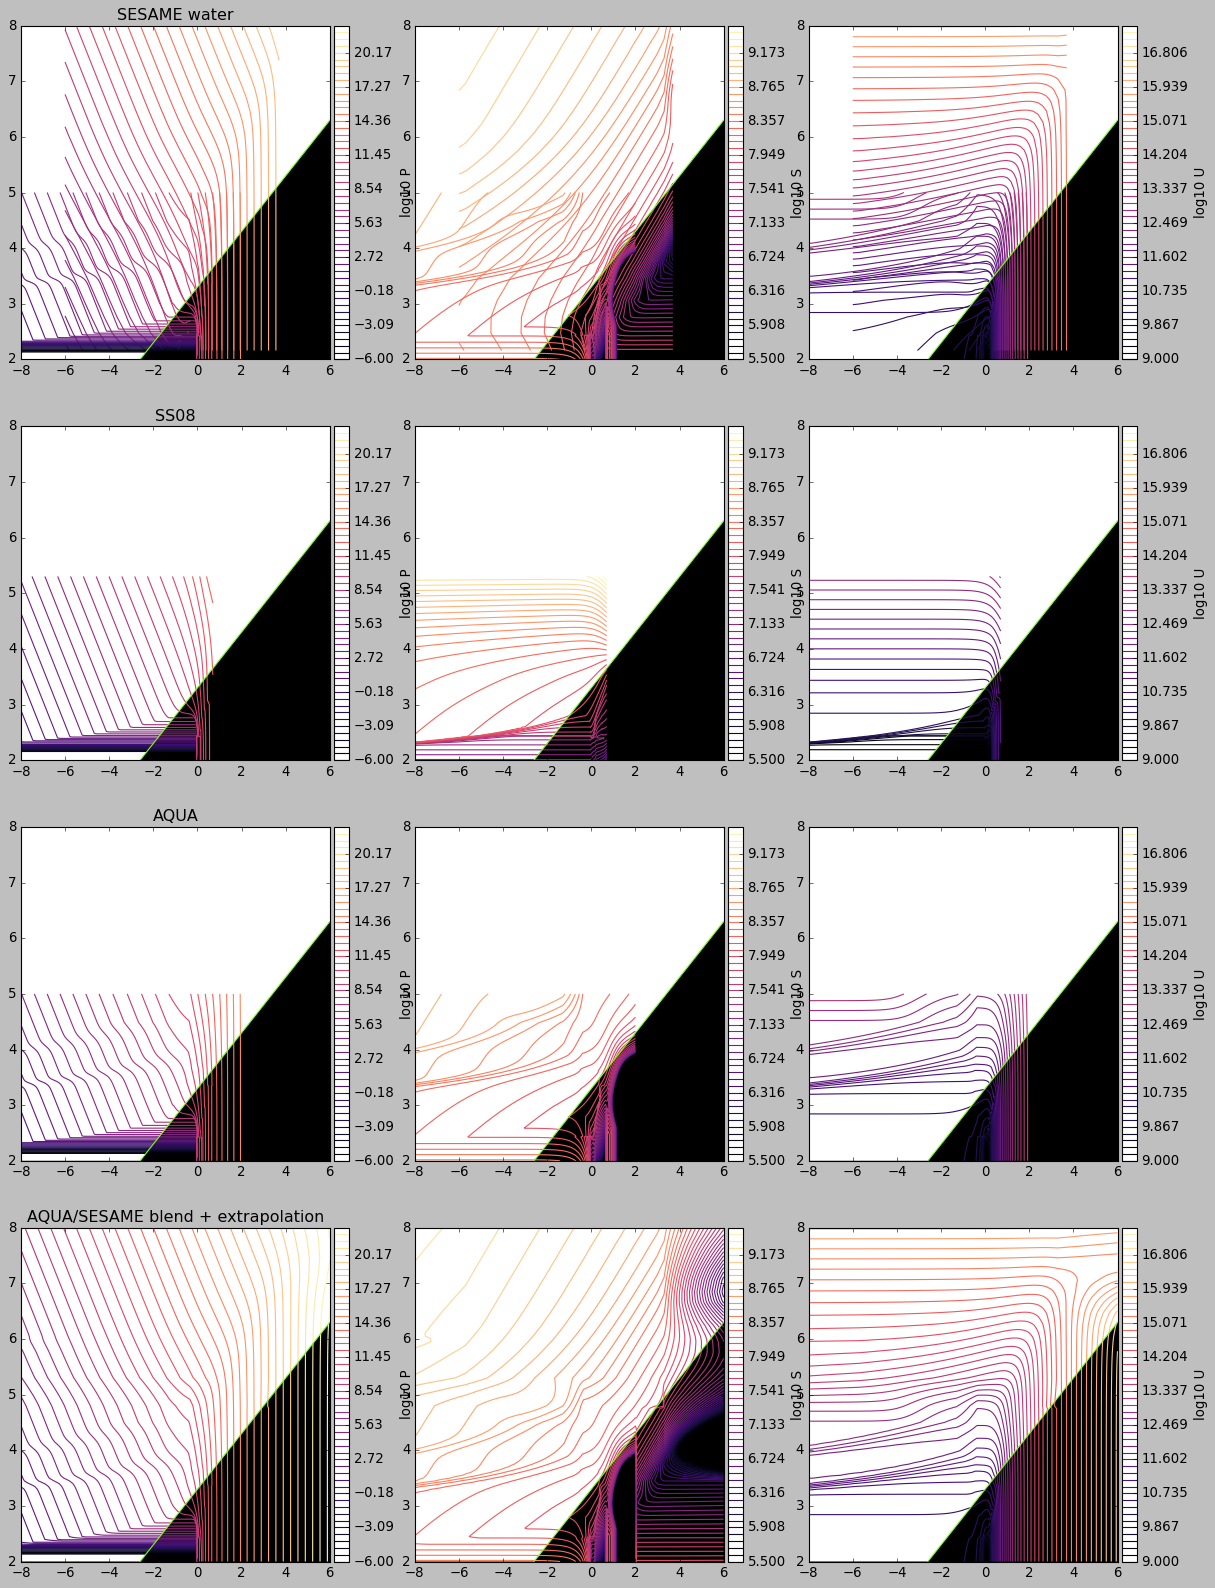

In [9]:
Pvmin = -6.
Pvmax = 22.5
Plevels = np.linspace(Pvmin, Pvmax, 50)

Svmin = 5.5
Svmax = 9.5
Slevels = np.linspace(Svmin, Svmax, 50)

Uvmin = 9
Uvmax = 17.5
Ulevels = np.linspace(Uvmin, Uvmax, 50)

fig, axes  = plt.subplots(4,3,figsize=(18,24))

# row 0: SESAME H2O
divider00 = make_axes_locatable(axes[0,0])
cax00 = divider00.append_axes('right', size='5%', pad=0.05)
cs00 = axes[0,0].contour(h2o.log10rhogrid, h2o.log10Tgrid, h2o.log10Pgrid, levels=Plevels, cmap='magma',alpha=1,vmin=Pvmin, vmax=Pvmax)
fig.colorbar(cs00, cax=cax00, orientation='vertical',label='log10 P')

divider01 = make_axes_locatable(axes[0,1])
cax01 = divider01.append_axes('right', size='5%', pad=0.05)
cs01 = axes[0,1].contour(h2o.log10rhogrid, h2o.log10Tgrid, h2o.log10Sgrid, levels=Slevels, cmap='magma',alpha=1,vmin=Svmin, vmax=Svmax)
fig.colorbar(cs01, cax=cax01, orientation='vertical',label='log10 S')

divider02 = make_axes_locatable(axes[0,2])
cax02 = divider02.append_axes('right', size='5%', pad=0.05)
cs02 = axes[0,2].contour(h2o.log10rhogrid, h2o.log10Tgrid, h2o.log10Ugrid, levels=Ulevels, cmap='magma',alpha=1,vmin=Uvmin, vmax=Uvmax)
fig.colorbar(cs02, cax=cax02, orientation='vertical',label='log10 U')

# row 1: SS08 H2O
divider10 = make_axes_locatable(axes[1,0])
cax10 = divider10.append_axes('right', size='5%', pad=0.05)
cs10 = axes[1,0].contour(ss08.log10rhogrid, ss08.log10Tgrid, ss08.log10Pgrid, levels=Plevels, cmap='magma',alpha=1,vmin=Pvmin, vmax=Pvmax)
fig.colorbar(cs10, cax=cax10, orientation='vertical',label='log10 P')

divider11 = make_axes_locatable(axes[1,1])
cax11 = divider11.append_axes('right', size='5%', pad=0.05)
cs11 = axes[1,1].contour(ss08.log10rhogrid, ss08.log10Tgrid, ss08.log10Sgrid, levels=Slevels, cmap='magma',alpha=1,vmin=Svmin, vmax=Svmax)
fig.colorbar(cs11, cax=cax11, orientation='vertical',label='log10 S')

divider12 = make_axes_locatable(axes[1,2])
cax12 = divider12.append_axes('right', size='5%', pad=0.05)
cs12 = axes[1,2].contour(ss08.log10rhogrid, ss08.log10Tgrid, ss08.log10Ugrid, levels=Ulevels, cmap='magma',alpha=1,vmin=Uvmin, vmax=Uvmax)
fig.colorbar(cs12, cax=cax12, orientation='vertical',label='log10 U')

# row 2: AQUA H2O
divider20 = make_axes_locatable(axes[2,0])
cax20 = divider20.append_axes('right', size='5%', pad=0.05)
cs20 = axes[0,0].contour(aqua.log10rhogrid, aqua.log10Tgrid, aqua.log10Pgrid, levels=Plevels, cmap='magma',alpha=1,vmin=Pvmin, vmax=Pvmax)
cs20 = axes[2,0].contour(aqua.log10rhogrid, aqua.log10Tgrid, aqua.log10Pgrid, levels=Plevels, cmap='magma',alpha=1,vmin=Pvmin, vmax=Pvmax)
fig.colorbar(cs20, cax=cax20, orientation='vertical',label='log10 P')

divider21 = make_axes_locatable(axes[2,1])
cax21 = divider21.append_axes('right', size='5%', pad=0.05)
cs21 = axes[0,1].contour(aqua.log10rhogrid, aqua.log10Tgrid, aqua.log10Sgrid, levels=Slevels, cmap='magma',alpha=1,vmin=Svmin, vmax=Svmax)
cs21 = axes[2,1].contour(aqua.log10rhogrid, aqua.log10Tgrid, aqua.log10Sgrid, levels=Slevels, cmap='magma',alpha=1,vmin=Svmin, vmax=Svmax)
fig.colorbar(cs21, cax=cax21, orientation='vertical',label='log10 S')

divider22 = make_axes_locatable(axes[2,2])
cax22 = divider22.append_axes('right', size='5%', pad=0.05)
cs22 = axes[0,2].contour(aqua.log10rhogrid, aqua.log10Tgrid, aqua.log10Ugrid, levels=Ulevels, cmap='magma',alpha=1,vmin=Uvmin, vmax=Uvmax)
cs22 = axes[2,2].contour(aqua.log10rhogrid, aqua.log10Tgrid, aqua.log10Ugrid, levels=Ulevels, cmap='magma',alpha=1,vmin=Uvmin, vmax=Uvmax)
fig.colorbar(cs22, cax=cax22, orientation='vertical',label='log10 U')

# row 3: blended H2O
divider30 = make_axes_locatable(axes[3,0])
cax30 = divider30.append_axes('right', size='5%', pad=0.05)
#cs30 = axes[2,0].contour(blended_h2o.log10rhogrid, blended_h2o.log10Tgrid, blended_h2o.log10Pgrid, levels=Plevels, cmap='magma',alpha=1,vmin=Pvmin, vmax=Pvmax)
cs30 = axes[3,0].contour(blended_h2o.log10rhogrid, blended_h2o.log10Tgrid, blended_h2o.log10Pgrid, levels=Plevels, cmap='magma',alpha=1,vmin=Pvmin, vmax=Pvmax)
fig.colorbar(cs30, cax=cax30, orientation='vertical',label='log10 P')

divider31 = make_axes_locatable(axes[3,1])
cax31 = divider31.append_axes('right', size='5%', pad=0.05)
#cs31 = axes[2,1].contour(blended_h2o.log10rhogrid, blended_h2o.log10Tgrid, blended_h2o.log10Sgrid, levels=Slevels, cmap='magma',alpha=1,vmin=Svmin, vmax=Svmax)
cs31 = axes[3,1].contour(blended_h2o.log10rhogrid, blended_h2o.log10Tgrid, blended_h2o.log10Sgrid, levels=Slevels, cmap='magma',alpha=1,vmin=Svmin, vmax=Svmax)
fig.colorbar(cs31, cax=cax31, orientation='vertical',label='log10 S')

divider32 = make_axes_locatable(axes[3,2])
cax32 = divider32.append_axes('right', size='5%', pad=0.05)
#cs32 = axes[2,2].contour(blended_h2o.log10rhogrid, blended_h2o.log10Tgrid, blended_h2o.log10Ugrid, levels=Ulevels, cmap='magma',alpha=1,vmin=Uvmin, vmax=Uvmax)
cs32 = axes[3,2].contour(blended_h2o.log10rhogrid, blended_h2o.log10Tgrid, blended_h2o.log10Ugrid, levels=Ulevels, cmap='magma',alpha=1,vmin=Uvmin, vmax=Uvmax)
fig.colorbar(cs32, cax=cax32, orientation='vertical',label='log10 U')

axes[0,0].set_title("SESAME water")
axes[1,0].set_title("SS08")
axes[2,0].set_title("AQUA")
axes[3,0].set_title("AQUA/SESAME blend + extrapolation")

for ax in np.ravel(axes):
    ax.set_xlim(-8.,6.)
    ax.set_ylim(2.,8.)
    ax.plot(np.linspace(-8,6,50), 3.3 + (1./2.)*np.linspace(-8,6,50) + np.log10(1) - (5./3)*np.log10(1), ls='-', color='#7FFF00')
    ax.fill_between(x=np.linspace(-8,6,50), y1=2,y2=3.3 + (1./2.)*np.linspace(-8,6,50) + np.log10(1) - (5./3)*np.log10(1),color='k')
    
plt.show()

In [10]:
# save blended H2O table data
outfile = open("./my_Ztables/blended_h2o.pkl","wb")
pickle.dump(blended_h2o,outfile)
outfile.close()

# Rock

In [11]:
# just extrapolate the ANEOS forsterite EoS
blended_rock  = simple_table()
desired_Tarr = np.arange(2.,8.04,0.05)
desired_rhoarr=np.arange(-8.0,6.04, 0.05)

blended_rock.log10Tgrid, blended_rock.log10rhogrid = np.meshgrid(desired_Tarr, desired_rhoarr)
blended_rock.log10Pgrid = np.zeros_like(blended_rock.log10Tgrid)
blended_rock.log10Sgrid = np.zeros_like(blended_rock.log10Tgrid)
blended_rock.log10Ugrid = np.zeros_like(blended_rock.log10Tgrid)

# interpolate ANEOS forsterite for the ANEOS forsterite region
forsterite_nonan_log10Sgrid = copy.deepcopy(forsterite.log10Sgrid)
forsterite_nonan_log10Sgrid[np.isnan(forsterite_nonan_log10Sgrid)] = np.min(forsterite_nonan_log10Sgrid[~np.isnan(forsterite_nonan_log10Sgrid)])

forsterite_interp_log10P_given_log10rho_log10T_slinear = interpolate.RegularGridInterpolator(points=(forsterite.independent_arr_1, forsterite.independent_arr_2), values=forsterite.log10Pgrid.T, bounds_error=False, fill_value=None, method='slinear')
forsterite_interp_log10S_given_log10rho_log10T_slinear = interpolate.RegularGridInterpolator(points=(forsterite.independent_arr_1, forsterite.independent_arr_2), values=forsterite_nonan_log10Sgrid.T, bounds_error=False, fill_value=None, method='slinear')
forsterite_interp_log10U_given_log10rho_log10T_slinear = interpolate.RegularGridInterpolator(points=(forsterite.independent_arr_1, forsterite.independent_arr_2), values=forsterite.log10Ugrid.T, bounds_error=False, fill_value=None, method='slinear')

for i, rho in enumerate(desired_rhoarr[:189]): #covering log10rho <= 1.45 
    for j, T in enumerate(desired_Tarr[:98]): # covering log10T <= 6.9
        blended_rock.log10Pgrid[i,j] = forsterite_interp_log10P_given_log10rho_log10T_slinear((rho,T))
        blended_rock.log10Sgrid[i,j] = forsterite_interp_log10S_given_log10rho_log10T_slinear((rho,T))
        blended_rock.log10Ugrid[i,j] = forsterite_interp_log10U_given_log10rho_log10T_slinear((rho,T))


# interpolate/extrapolate SESAME basalt table for the rest
basalt_nonan_log10Pgrid = copy.deepcopy(basalt.log10Pgrid)
basalt_nonan_log10Pgrid[np.isnan(basalt_nonan_log10Pgrid)] = np.min(basalt_nonan_log10Pgrid[~np.isnan(basalt_nonan_log10Pgrid)])

basalt_nonan_log10Sgrid = copy.deepcopy(basalt.log10Sgrid)
basalt_nonan_log10Sgrid[~np.isfinite(basalt_nonan_log10Sgrid)] = np.min(basalt_nonan_log10Sgrid[np.isfinite(basalt_nonan_log10Sgrid)])

print(np.min(basalt_nonan_log10Sgrid))
print(np.max(basalt_nonan_log10Sgrid))

basalt_interp_log10P_given_log10rho_log10T_slinear = interpolate.RegularGridInterpolator(points=(basalt.independent_arr_1, basalt.independent_arr_2), values=basalt_nonan_log10Pgrid.T, bounds_error=False, fill_value=None, method='slinear')
basalt_interp_log10S_given_log10rho_log10T_slinear = interpolate.RegularGridInterpolator(points=(basalt.independent_arr_1, basalt.independent_arr_2), values=basalt_nonan_log10Sgrid.T, bounds_error=False, fill_value=None, method='slinear')
basalt_interp_log10U_given_log10rho_log10T_slinear = interpolate.RegularGridInterpolator(points=(basalt.independent_arr_1, basalt.independent_arr_2), values=basalt.log10Ugrid.T, bounds_error=False, fill_value=None, method='slinear')


for i, rho in enumerate(desired_rhoarr[189:]):
    for j, T in enumerate(desired_Tarr):
        blended_rock.log10Pgrid[i+189,j] = basalt_interp_log10P_given_log10rho_log10T_slinear((rho,T))
        blended_rock.log10Sgrid[i+189,j] = basalt_interp_log10S_given_log10rho_log10T_slinear((rho,T))
        blended_rock.log10Ugrid[i+189,j] = basalt_interp_log10U_given_log10rho_log10T_slinear((rho,T))

for i, rho in enumerate(desired_rhoarr):
    for j, T in enumerate(desired_Tarr[98:]):
        blended_rock.log10Pgrid[i,j+98] = basalt_interp_log10P_given_log10rho_log10T_slinear((rho,T))
        blended_rock.log10Sgrid[i,j+98] = basalt_interp_log10S_given_log10rho_log10T_slinear((rho,T))
        blended_rock.log10Ugrid[i,j+98] = basalt_interp_log10U_given_log10rho_log10T_slinear((rho,T))

# in blend region: average ANEOS and SESAME
for i,rho in enumerate(desired_rhoarr[184:194]): 
    for j, T in enumerate(desired_Tarr[:98]): #covering 5 < log10T <= 8
        blended_rock.log10Pgrid[i+184,j] = (i/10)*basalt_interp_log10P_given_log10rho_log10T_slinear((rho,T)) + ((10-i)/10)*forsterite_interp_log10P_given_log10rho_log10T_slinear((rho,T))
        blended_rock.log10Sgrid[i+184,j] = (i/10)*basalt_interp_log10S_given_log10rho_log10T_slinear((rho,T)) + ((10-i)/10)*forsterite_interp_log10S_given_log10rho_log10T_slinear((rho,T))
        blended_rock.log10Ugrid[i+184,j] = (i/10)*basalt_interp_log10U_given_log10rho_log10T_slinear((rho,T)) + ((10-i)/10)*forsterite_interp_log10U_given_log10rho_log10T_slinear((rho,T))

for i,rho in enumerate(desired_rhoarr[:189]): 
    for j, T in enumerate(desired_Tarr[93:103]): #covering 5 < log10T <= 8
        blended_rock.log10Pgrid[i,j+93] = (j/10)*basalt_interp_log10P_given_log10rho_log10T_slinear((rho,T)) + ((10-j)/10)*forsterite_interp_log10P_given_log10rho_log10T_slinear((rho,T))
        blended_rock.log10Sgrid[i,j+93] = (j/10)*basalt_interp_log10S_given_log10rho_log10T_slinear((rho,T)) + ((10-j)/10)*forsterite_interp_log10S_given_log10rho_log10T_slinear((rho,T))
        blended_rock.log10Ugrid[i,j+93] = (j/10)*basalt_interp_log10U_given_log10rho_log10T_slinear((rho,T)) + ((10-j)/10)*forsterite_interp_log10U_given_log10rho_log10T_slinear((rho,T))


3.8113660834378305
9.11620223645842


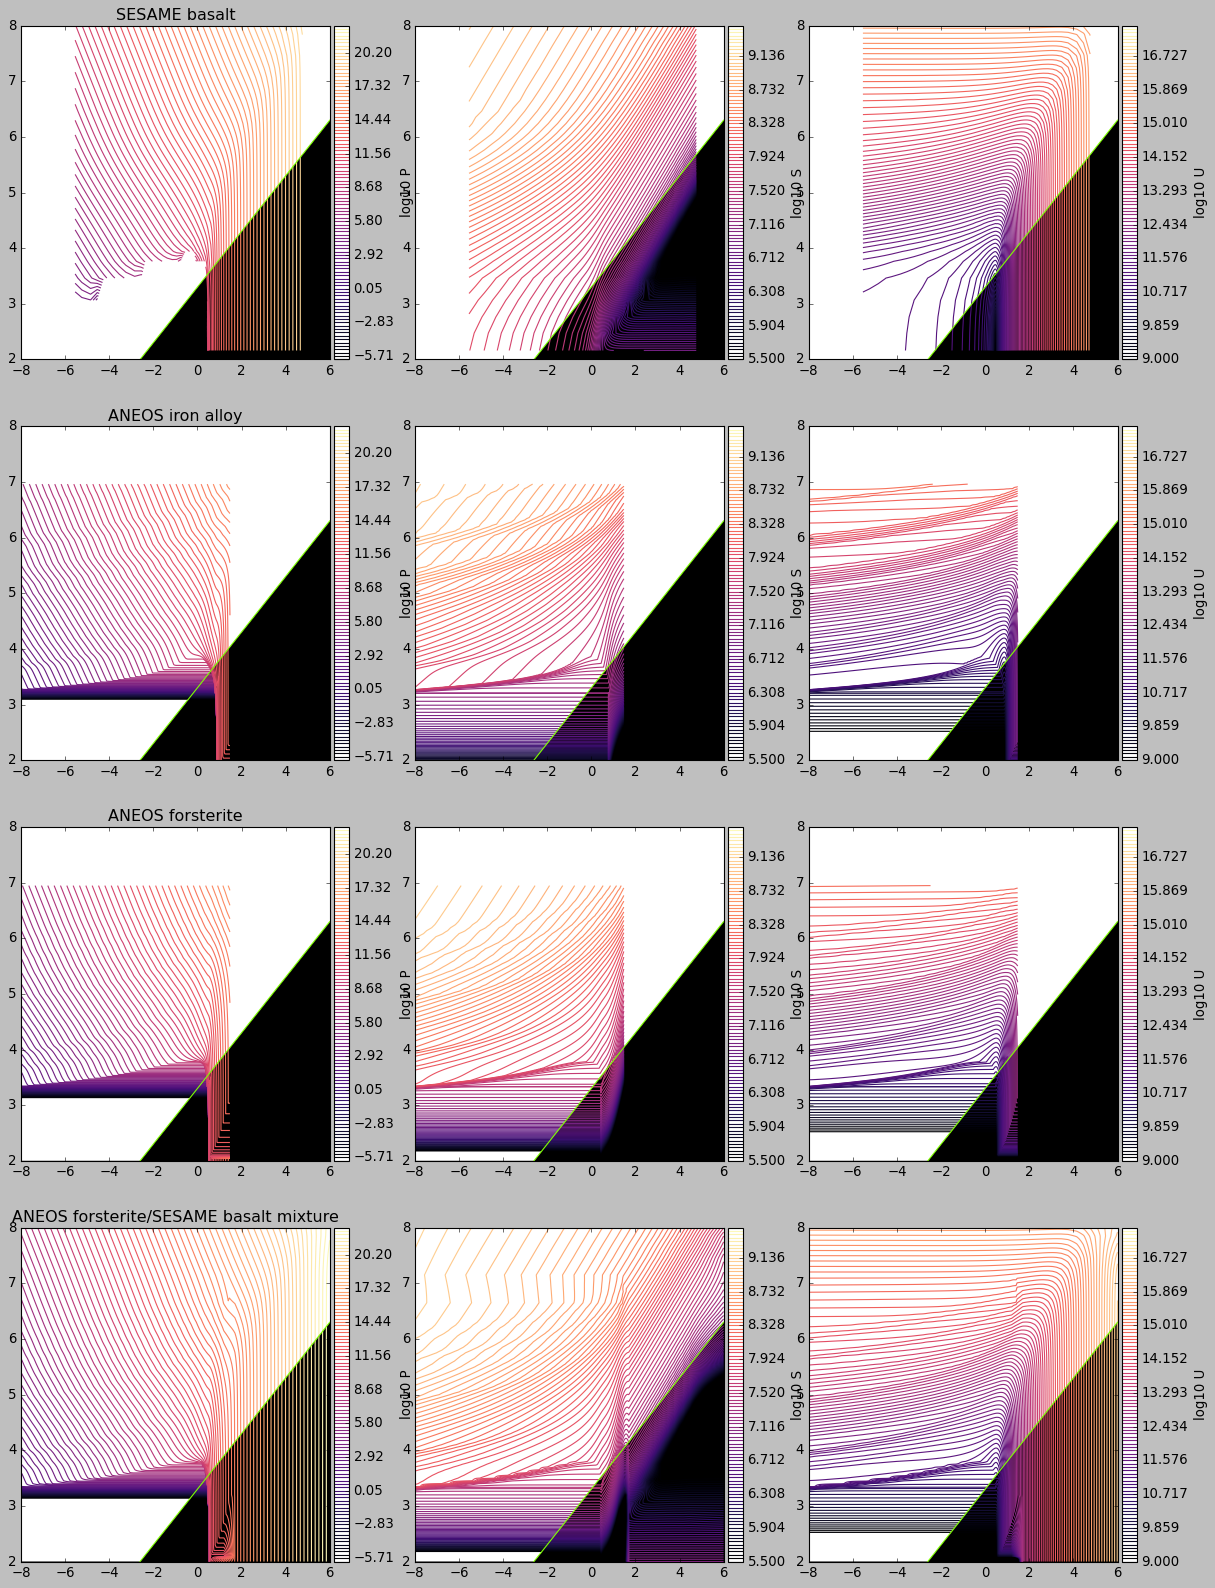

In [12]:
# rock

Pvmin = -6.
Pvmax = 22.5
Plevels = np.linspace(Pvmin, Pvmax, 100)

Svmin = 5.5
Svmax = 9.5
Slevels = np.linspace(Svmin, Svmax, 100)

Uvmin = 9
Uvmax = 17.5
Ulevels = np.linspace(Uvmin, Uvmax, 100)

fig, axes  = plt.subplots(4,3,figsize=(18,24))

# row 0: SESAME basalt
divider00 = make_axes_locatable(axes[0,0])
cax00 = divider00.append_axes('right', size='5%', pad=0.05)
cs00 = axes[0,0].contour(basalt.log10rhogrid, basalt.log10Tgrid, basalt.log10Pgrid, levels=Plevels, cmap='magma',alpha=1,vmin=Pvmin, vmax=Pvmax)
fig.colorbar(cs00, cax=cax00, orientation='vertical',label='log10 P')

divider01 = make_axes_locatable(axes[0,1])
cax01 = divider01.append_axes('right', size='5%', pad=0.05)
cs01 = axes[0,1].contour(basalt.log10rhogrid, basalt.log10Tgrid, basalt.log10Sgrid, levels=Slevels, cmap='magma',alpha=1,vmin=Svmin, vmax=Svmax)
fig.colorbar(cs01, cax=cax01, orientation='vertical',label='log10 S')

divider02 = make_axes_locatable(axes[0,2])
cax02 = divider02.append_axes('right', size='5%', pad=0.05)
cs02 = axes[0,2].contour(basalt.log10rhogrid, basalt.log10Tgrid, basalt.log10Ugrid, levels=Ulevels, cmap='magma',alpha=1,vmin=Uvmin, vmax=Uvmax)
fig.colorbar(cs02, cax=cax02, orientation='vertical',label='log10 U')

# row 1: ANEOS iron alloy
divider10 = make_axes_locatable(axes[1,0])
cax10 = divider10.append_axes('right', size='5%', pad=0.05)
cs10 = axes[1,0].contour(iron_alloy.log10rhogrid, iron_alloy.log10Tgrid, iron_alloy.log10Pgrid, levels=Plevels, cmap='magma',alpha=1,vmin=Pvmin, vmax=Pvmax)
fig.colorbar(cs10, cax=cax10, orientation='vertical',label='log10 P')

divider11 = make_axes_locatable(axes[1,1])
cax11 = divider11.append_axes('right', size='5%', pad=0.05)
cs11 = axes[1,1].contour(iron_alloy.log10rhogrid, iron_alloy.log10Tgrid, iron_alloy.log10Sgrid, levels=Slevels, cmap='magma',alpha=1,vmin=Svmin, vmax=Svmax)
fig.colorbar(cs11, cax=cax11, orientation='vertical',label='log10 S')

divider12 = make_axes_locatable(axes[1,2])
cax12 = divider12.append_axes('right', size='5%', pad=0.05)
cs12 = axes[1,2].contour(iron_alloy.log10rhogrid, iron_alloy.log10Tgrid, iron_alloy.log10Ugrid, levels=Ulevels, cmap='magma',alpha=1,vmin=Uvmin, vmax=Uvmax)
fig.colorbar(cs12, cax=cax12, orientation='vertical',label='log10 U')

# row 2: ANEOS forsterite
divider20 = make_axes_locatable(axes[2,0])
cax20 = divider20.append_axes('right', size='5%', pad=0.05)
cs20 = axes[2,0].contour(forsterite.log10rhogrid, forsterite.log10Tgrid, forsterite.log10Pgrid, levels=Plevels, cmap='magma',alpha=1,vmin=Pvmin, vmax=Pvmax)
#cs20 = axes[2,0].contour(aqua.log10rhogrid, aqua.log10Tgrid, aqua.log10Pgrid, levels=Plevels, cmap='magma',alpha=1,vmin=Pvmin, vmax=Pvmax)
fig.colorbar(cs20, cax=cax20, orientation='vertical',label='log10 P')

divider21 = make_axes_locatable(axes[2,1])
cax21 = divider21.append_axes('right', size='5%', pad=0.05)
cs21 = axes[2,1].contour(forsterite.log10rhogrid, forsterite.log10Tgrid, forsterite.log10Sgrid, levels=Slevels, cmap='magma',alpha=1,vmin=Svmin, vmax=Svmax)
#cs21 = axes[2,1].contour(aqua.log10rhogrid, aqua.log10Tgrid, aqua.log10Sgrid, levels=Slevels, cmap='magma',alpha=1,vmin=Svmin, vmax=Svmax)
fig.colorbar(cs21, cax=cax21, orientation='vertical',label='log10 S')

divider22 = make_axes_locatable(axes[2,2])
cax22 = divider22.append_axes('right', size='5%', pad=0.05)
cs22 = axes[2,2].contour(forsterite.log10rhogrid, forsterite.log10Tgrid, forsterite.log10Ugrid, levels=Ulevels, cmap='magma',alpha=1,vmin=Uvmin, vmax=Uvmax)
#cs22 = axes[2,2].contour(aqua.log10rhogrid, aqua.log10Tgrid, aqua.log10Ugrid, levels=Ulevels, cmap='magma',alpha=1,vmin=Uvmin, vmax=Uvmax)
fig.colorbar(cs22, cax=cax22, orientation='vertical',label='log10 U')

# row 3: ANEOS forsterite, extrapolated
divider30 = make_axes_locatable(axes[3,0])
cax30 = divider30.append_axes('right', size='5%', pad=0.05)
#cs30 = axes[3,0].contour(forsterite.log10rhogrid, forsterite.log10Tgrid, forsterite.log10Pgrid, levels=Plevels, cmap='magma',alpha=1,vmin=Pvmin, vmax=Pvmax)
cs30 = axes[3,0].contour(blended_rock.log10rhogrid, blended_rock.log10Tgrid, blended_rock.log10Pgrid, levels=Plevels, cmap='magma',alpha=1,vmin=Pvmin, vmax=Pvmax)
fig.colorbar(cs30, cax=cax30, orientation='vertical',label='log10 P')

divider31 = make_axes_locatable(axes[3,1])
cax31 = divider31.append_axes('right', size='5%', pad=0.05)
#cs31 = axes[3,1].contour(forsterite.log10rhogrid, forsterite.log10Tgrid, forsterite.log10Sgrid, levels=Slevels, cmap='magma',alpha=1,vmin=Svmin, vmax=Svmax)
cs31 = axes[3,1].contour(blended_rock.log10rhogrid, blended_rock.log10Tgrid, blended_rock.log10Sgrid, levels=Slevels, cmap='magma',alpha=1,vmin=Svmin, vmax=Svmax)
fig.colorbar(cs31, cax=cax31, orientation='vertical',label='log10 S')

divider32 = make_axes_locatable(axes[3,2])
cax32 = divider32.append_axes('right', size='5%', pad=0.05)
#cs32 = axes[3,2].contour(forsterite.log10rhogrid, forsterite.log10Tgrid, forsterite.log10Ugrid, levels=Ulevels, cmap='magma',alpha=1,vmin=Uvmin, vmax=Uvmax)
cs32 = axes[3,2].contour(blended_rock.log10rhogrid, blended_rock.log10Tgrid, blended_rock.log10Ugrid, levels=Ulevels, cmap='magma',alpha=1,vmin=Uvmin, vmax=Uvmax)
fig.colorbar(cs32, cax=cax32, orientation='vertical',label='log10 U')


axes[0,0].set_title("SESAME basalt")
axes[1,0].set_title("ANEOS iron alloy")
axes[2,0].set_title("ANEOS forsterite")
axes[3,0].set_title("ANEOS forsterite/SESAME basalt mixture")

for ax in np.ravel(axes):
    ax.set_xlim(-8.,6.)
    ax.set_ylim(2.,8.)
    ax.plot(np.linspace(-8,6,50), 3.3 + (1./2.)*np.linspace(-8,6,50) + np.log10(1) - (5./3)*np.log10(1), ls='-', color='#7FFF00')
    ax.fill_between(x=np.linspace(-8,6,50), y1=2,y2=3.3 + (1./2.)*np.linspace(-8,6,50) + np.log10(1) - (5./3)*np.log10(1),color='k')
    
plt.show()

In [13]:
# save blended rock table data
outfile = open("./my_Ztables/blended_rock.pkl","wb")
pickle.dump(blended_rock,outfile)
outfile.close()

# Iron

In [14]:
print(np.min(iron.log10rhogrid))
print(np.max(iron.log10rhogrid))

-1.2123403129026158
5.195899652409234


In [16]:
desired_Tarr = np.arange(2.,8.04,0.05)
desired_rhoarr=np.arange(-8.0,6.04, 0.05)

print(desired_Tarr[98:])


[6.9  6.95 7.   7.05 7.1  7.15 7.2  7.25 7.3  7.35 7.4  7.45 7.5  7.55
 7.6  7.65 7.7  7.75 7.8  7.85 7.9  7.95 8.  ]


In [17]:
blended_fe  = simple_table()
desired_Tarr = np.arange(2.,8.04,0.05)
desired_rhoarr=np.arange(-8.0,6.04, 0.05)

blended_fe.log10Tgrid, blended_fe.log10rhogrid = np.meshgrid(desired_Tarr, desired_rhoarr)
blended_fe.log10Pgrid = np.zeros_like(blended_fe.log10Tgrid)
blended_fe.log10Sgrid = np.zeros_like(blended_fe.log10Tgrid)
blended_fe.log10Ugrid = np.zeros_like(blended_fe.log10Tgrid)


# interpolate ANEOS for the ANEOS region
aneos_nonan_log10Sgrid = copy.deepcopy(an_iron.log10Sgrid)
aneos_nonan_log10Sgrid[np.isnan(aneos_nonan_log10Sgrid)] = np.min(aneos_nonan_log10Sgrid[~np.isnan(aneos_nonan_log10Sgrid)])

aneos_interp_log10P_given_log10rho_log10T_slinear = interpolate.RegularGridInterpolator(points=(an_iron.independent_arr_1, an_iron.independent_arr_2), values=an_iron.log10Pgrid.T, bounds_error=False, fill_value=None, method='slinear')
aneos_interp_log10S_given_log10rho_log10T_slinear = interpolate.RegularGridInterpolator(points=(an_iron.independent_arr_1[0:250], an_iron.independent_arr_2[0:830]), values=aneos_nonan_log10Sgrid[:830,:250].T, bounds_error=False, fill_value=None, method='slinear')
aneos_interp_log10U_given_log10rho_log10T_slinear = interpolate.RegularGridInterpolator(points=(an_iron.independent_arr_1, an_iron.independent_arr_2), values=an_iron.log10Ugrid.T,bounds_error=False, fill_value=None, method='slinear')

for i, rho in enumerate(desired_rhoarr[:189]): # log10rho <= 1.45
    for j, T in enumerate(desired_Tarr[:98]): # log10T <= 6.9
        blended_fe.log10Pgrid[i,j] = aneos_interp_log10P_given_log10rho_log10T_slinear((rho,T))
        blended_fe.log10Ugrid[i,j] = aneos_interp_log10U_given_log10rho_log10T_slinear((rho,T))

# SESAME has no S data, so use ANEOS for the whole region
for i, rho in enumerate(desired_rhoarr): 
    for j, T in enumerate(desired_Tarr):
        blended_fe.log10Sgrid[i,j] = aneos_interp_log10S_given_log10rho_log10T_slinear((rho,T))

# interpolate SESAME for the SESAME region
sesame_nonan_log10Pgrid = copy.deepcopy(iron.log10Pgrid)
sesame_nonan_log10Pgrid[~np.isfinite(sesame_nonan_log10Pgrid)] = np.min(sesame_nonan_log10Pgrid[np.isfinite(sesame_nonan_log10Pgrid)])

# note that SESAME has no S data
sesame_interp_log10P_given_log10rho_log10T_slinear = interpolate.RegularGridInterpolator(points=(iron.independent_arr_1, iron.independent_arr_2), values=sesame_nonan_log10Pgrid.T, bounds_error=False, fill_value=None, method='slinear')
sesame_interp_log10U_given_log10rho_log10T_slinear = interpolate.RegularGridInterpolator(points=(iron.independent_arr_1, iron.independent_arr_2), values=iron.log10Ugrid.T,bounds_error=False, fill_value=None, method='slinear')

for i, rho in enumerate(desired_rhoarr[189:]): # log10rho <= 1.45
    for j, T in enumerate(desired_Tarr): # log10T <= 6.9
        blended_fe.log10Pgrid[i+189,j] = sesame_interp_log10P_given_log10rho_log10T_slinear((rho,T))
        blended_fe.log10Ugrid[i+189,j] = sesame_interp_log10U_given_log10rho_log10T_slinear((rho,T))

for i, rho in enumerate(desired_rhoarr): # log10rho <= 1.45
    for j, T in enumerate(desired_Tarr[98:]): # log10T <= 6.9
        blended_fe.log10Pgrid[i,j+98] = sesame_interp_log10P_given_log10rho_log10T_slinear((rho,T))
        blended_fe.log10Ugrid[i,j+98] = sesame_interp_log10U_given_log10rho_log10T_slinear((rho,T))

# in blend region: average ANEOS and SESAME
for i,rho in enumerate(desired_rhoarr[184:194]): 
    for j, T in enumerate(desired_Tarr[:98]): #covering 5 < log10T <= 8
        blended_fe.log10Pgrid[i+184,j] = (i/10)*sesame_interp_log10P_given_log10rho_log10T_slinear((rho,T)) + ((10-i)/10)*aneos_interp_log10P_given_log10rho_log10T_slinear((rho,T))
        blended_fe.log10Ugrid[i+184,j] = (i/10)*sesame_interp_log10U_given_log10rho_log10T_slinear((rho,T)) + ((10-i)/10)*aneos_interp_log10U_given_log10rho_log10T_slinear((rho,T))

for i,rho in enumerate(desired_rhoarr[:189]): 
    for j, T in enumerate(desired_Tarr[93:103]): #covering 5 < log10T <= 8
        blended_fe.log10Pgrid[i,j+93] = (j/10)*sesame_interp_log10P_given_log10rho_log10T_slinear((rho,T)) + ((10-j)/10)*aneos_interp_log10P_given_log10rho_log10T_slinear((rho,T))
        blended_fe.log10Ugrid[i,j+93] = (j/10)*sesame_interp_log10U_given_log10rho_log10T_slinear((rho,T)) + ((10-j)/10)*aneos_interp_log10U_given_log10rho_log10T_slinear((rho,T))


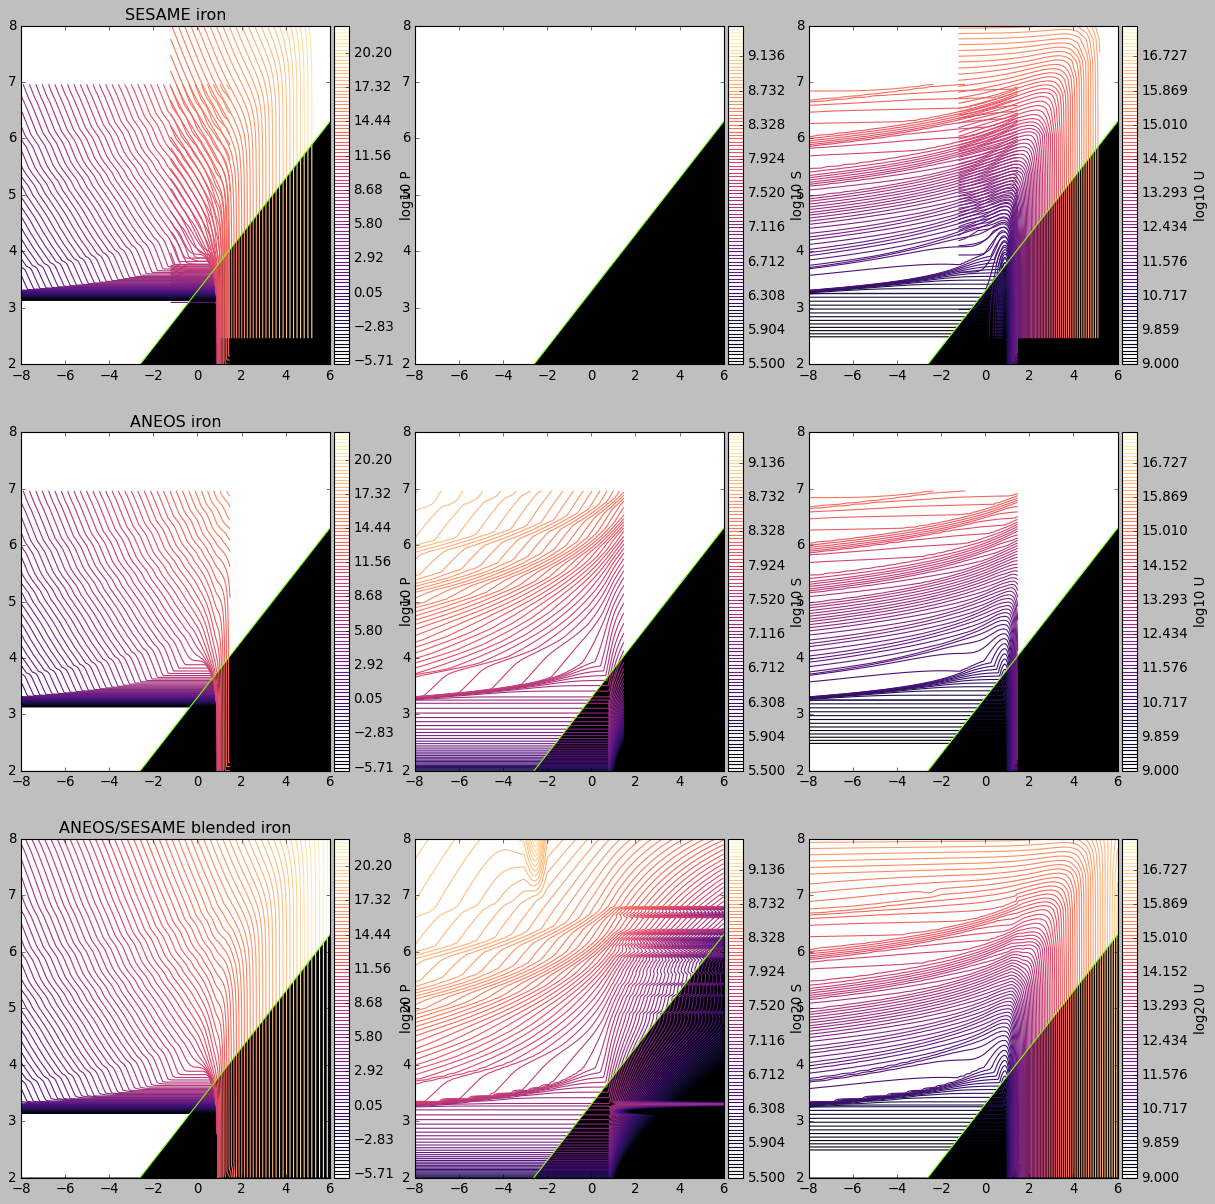

In [18]:
# iron
Pvmin = -6.
Pvmax = 22.5
Plevels = np.linspace(Pvmin, Pvmax, 100)

Svmin = 5.5
Svmax = 9.5
Slevels = np.linspace(Svmin, Svmax, 100)

Uvmin = 9
Uvmax = 17.5
Ulevels = np.linspace(Uvmin, Uvmax, 100)

fig, axes  = plt.subplots(3,3,figsize=(18,18))

# row 0: SESAME iron
divider00 = make_axes_locatable(axes[0,0])
cax00 = divider00.append_axes('right', size='5%', pad=0.05)
cs00 = axes[0,0].contour(iron.log10rhogrid, iron.log10Tgrid, iron.log10Pgrid, levels=Plevels, cmap='magma',alpha=1,vmin=Pvmin, vmax=Pvmax)
fig.colorbar(cs00, cax=cax00, orientation='vertical',label='log10 P')

divider01 = make_axes_locatable(axes[0,1])
cax01 = divider01.append_axes('right', size='5%', pad=0.05)
cs01 = axes[0,1].contour(iron.log10rhogrid, iron.log10Tgrid, iron.log10Sgrid, levels=Slevels, cmap='magma',alpha=1,vmin=Svmin, vmax=Svmax)
fig.colorbar(cs01, cax=cax01, orientation='vertical',label='log10 S')

divider02 = make_axes_locatable(axes[0,2])
cax02 = divider02.append_axes('right', size='5%', pad=0.05)
cs02 = axes[0,2].contour(iron.log10rhogrid, iron.log10Tgrid, iron.log10Ugrid, levels=Ulevels, cmap='magma',alpha=1,vmin=Uvmin, vmax=Uvmax)
fig.colorbar(cs02, cax=cax02, orientation='vertical',label='log10 U')

# row 1: ANEOS iron
divider10 = make_axes_locatable(axes[1,0])
cax10 = divider10.append_axes('right', size='5%', pad=0.05)
cs10 = axes[1,0].contour(an_iron.log10rhogrid, an_iron.log10Tgrid, an_iron.log10Pgrid, levels=Plevels, cmap='magma',alpha=1,vmin=Pvmin, vmax=Pvmax)
cs10 = axes[0,0].contour(an_iron.log10rhogrid, an_iron.log10Tgrid, an_iron.log10Pgrid, levels=Plevels, cmap='magma',alpha=1,vmin=Pvmin, vmax=Pvmax)
fig.colorbar(cs10, cax=cax10, orientation='vertical',label='log10 P')

divider11 = make_axes_locatable(axes[1,1])
cax11 = divider11.append_axes('right', size='5%', pad=0.05)
cs11 = axes[1,1].contour(an_iron.log10rhogrid, an_iron.log10Tgrid, an_iron.log10Sgrid, levels=Slevels, cmap='magma',alpha=1,vmin=Svmin, vmax=Svmax)
#cs11 = axes[0,1].contour(an_iron.log10rhogrid, an_iron.log10Tgrid, an_iron.log10Sgrid, levels=Slevels, cmap='magma',alpha=1,vmin=Svmin, vmax=Svmax)
fig.colorbar(cs11, cax=cax11, orientation='vertical',label='log10 S')

divider12 = make_axes_locatable(axes[1,2])
cax12 = divider12.append_axes('right', size='5%', pad=0.05)
cs12 = axes[1,2].contour(an_iron.log10rhogrid, an_iron.log10Tgrid, an_iron.log10Ugrid, levels=Ulevels, cmap='magma',alpha=1,vmin=Uvmin, vmax=Uvmax)
cs12 = axes[0,2].contour(an_iron.log10rhogrid, an_iron.log10Tgrid, an_iron.log10Ugrid, levels=Ulevels, cmap='magma',alpha=1,vmin=Uvmin, vmax=Uvmax)
fig.colorbar(cs12, cax=cax12, orientation='vertical',label='log10 U')

# row 2: ANEOS/SESAME blend. Note that entropy is purely extrapolated from ANEOS. 
divider20 = make_axes_locatable(axes[2,0])
cax20 = divider20.append_axes('right', size='5%', pad=0.05)
cs20 = axes[2,0].contour(blended_fe.log10rhogrid, blended_fe.log10Tgrid, blended_fe.log10Pgrid, levels=Plevels, cmap='magma',alpha=1,vmin=Pvmin, vmax=Pvmax)
fig.colorbar(cs20, cax=cax20, orientation='vertical',label='log20 P')

divider21 = make_axes_locatable(axes[2,1])
cax21 = divider21.append_axes('right', size='5%', pad=0.05)
cs21 = axes[2,1].contour(blended_fe.log10rhogrid, blended_fe.log10Tgrid, blended_fe.log10Sgrid, levels=Slevels, cmap='magma',alpha=1,vmin=Svmin, vmax=Svmax)
fig.colorbar(cs21, cax=cax21, orientation='vertical',label='log20 S')

divider22 = make_axes_locatable(axes[2,2])
cax22 = divider22.append_axes('right', size='5%', pad=0.05)
cs22 = axes[2,2].contour(blended_fe.log10rhogrid, blended_fe.log10Tgrid, blended_fe.log10Ugrid, levels=Ulevels, cmap='magma',alpha=1,vmin=Uvmin, vmax=Uvmax)
fig.colorbar(cs22, cax=cax22, orientation='vertical',label='log20 U')


axes[0,0].set_title("SESAME iron")
axes[1,0].set_title("ANEOS iron")
axes[2,0].set_title("ANEOS/SESAME blended iron")

for ax in np.ravel(axes):
    ax.set_xlim(-8.,6.)
    ax.set_ylim(2.,8.)
    ax.plot(np.linspace(-8,6,50), 3.3 + (1./2.)*np.linspace(-8,6,50) + np.log10(1) - (5./3)*np.log10(1), ls='-', color='#7FFF00')
    ax.fill_between(x=np.linspace(-8,6,50), y1=2,y2=3.3 + (1./2.)*np.linspace(-8,6,50) + np.log10(1) - (5./3)*np.log10(1),color='k')
    

plt.show()

In [19]:
# save blended rock table data
outfile = open("./my_Ztables/blended_iron.pkl","wb")
pickle.dump(blended_fe,outfile)
outfile.close()